In [5]:
!pip install --quiet yfinance prophet scikit-learn

In [10]:
import pandas as pd
df_all = pd.read_csv("/kaggle/input/big-tech-stock-prices/AAPL.csv")
df_all.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.515213,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.526476,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.422664,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.410790,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.453412,447610800


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_all["Date"] = pd.to_datetime(df_all["Date"])
df_all.set_index("Date", inplace=True)
df = df_all.sort_index()

In [12]:
print("Data shape:", df.shape)
display(df.describe().T)

Data shape: (3271, 6)


,count,mean,std,min,25%,50%,75%,max
Open,3271.0,5.127417e+01,4.731651e+01,6.870357e+00,1.896589e+01,2.974500e+01,5.689750e+01,1.826300e+02
High,3271.0,5.184588e+01,4.792672e+01,7.000000e+00,1.912161e+01,2.998000e+01,5.725625e+01,1.829400e+02
Low,3271.0,5.070855e+01,4.672011e+01,6.794643e+00,1.878000e+01,2.955500e+01,5.643500e+01,1.791200e+02
Close,3271.0,5.129715e+01,4.734434e+01,6.858929e+00,1.896554e+01,2.981250e+01,5.676125e+01,1.820100e+02
Adj Close,3271.0,4.944512e+01,4.781059e+01,5.846675e+00,1.662574e+01,2.738510e+01,5.487604e+01,1.809597e+02
Volume,3271.0,2.563255e+08,2.225768e+08,3.519590e+07,1.023724e+08,1.666740e+08,3.457554e+08,1.880998e+09


In [13]:
print("\nMissing values per column:")
print(df.isna().sum())


Missing values per column:
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


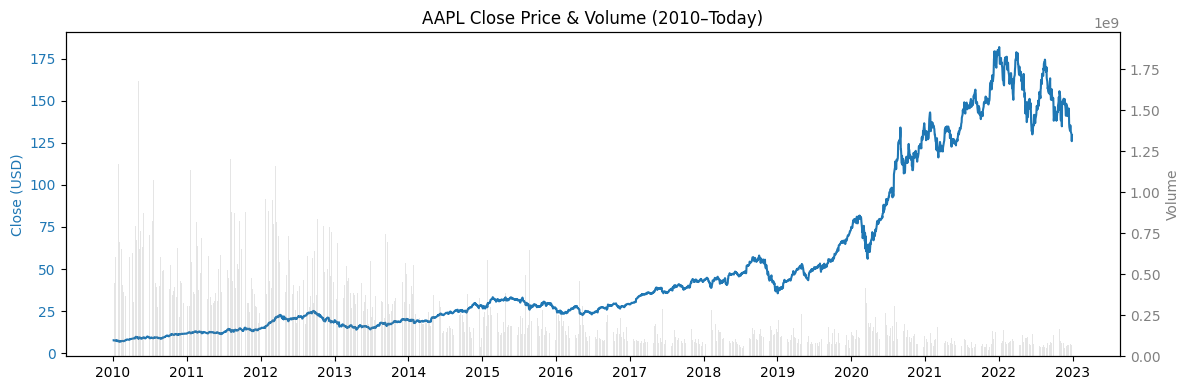

In [16]:
import matplotlib.dates as mdates

fig, ax1 = plt.subplots(figsize=(12,4))
ax1.plot(df.index, df["Close"], label="Close", color="tab:blue")
ax1.set_ylabel("Close (USD)", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax2 = ax1.twinx()
ax2.bar(df.index, df["Volume"], alpha=0.2, label="Volume", color="gray")
ax2.set_ylabel("Volume", color="gray")
ax2.tick_params(axis="y", labelcolor="gray")

plt.title("AAPL Close Price & Volume (2010–Today)")
plt.tight_layout()
plt.show()

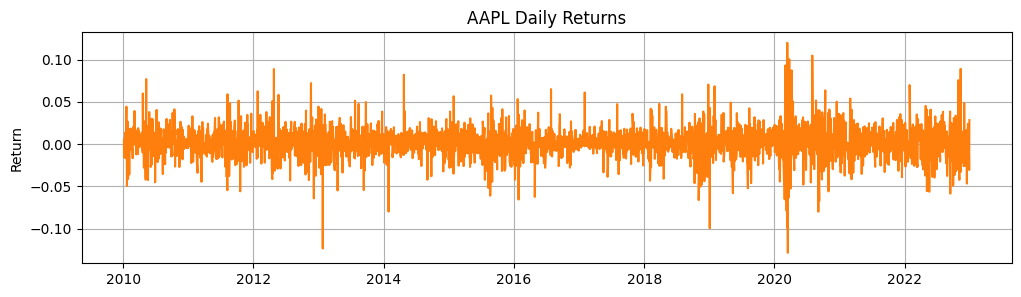

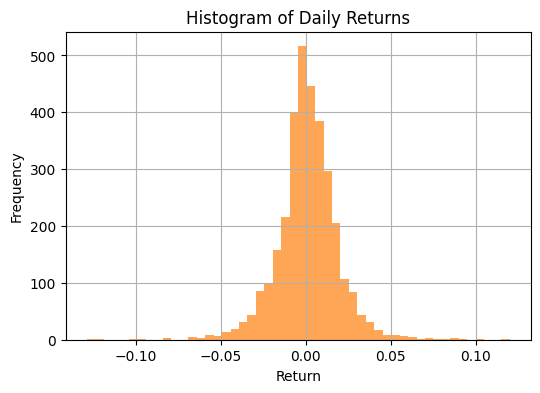

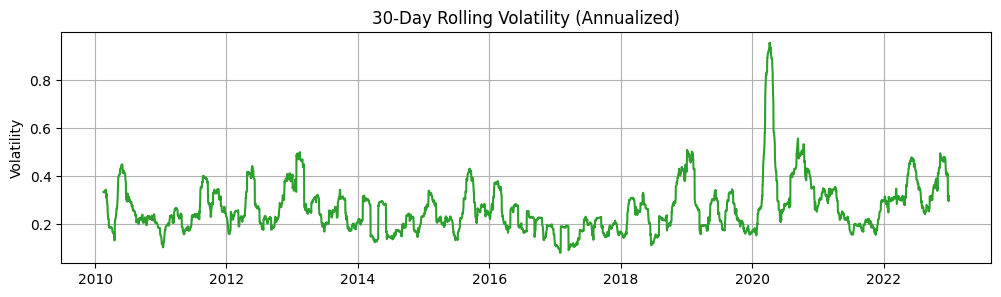

In [17]:
df["Return"] = df["Close"].pct_change()

plt.figure(figsize=(12,3))
plt.plot(df.index, df["Return"], color="tab:orange")
plt.title("AAPL Daily Returns")
plt.ylabel("Return"); plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.hist(df["Return"].dropna(), bins=50, alpha=0.7, color="tab:orange")
plt.title("Histogram of Daily Returns")
plt.xlabel("Return"); plt.ylabel("Frequency"); plt.grid(True); plt.show()

df["Volatility30"] = df["Return"].rolling(30).std() * np.sqrt(252)
plt.figure(figsize=(12,3))
plt.plot(df.index, df["Volatility30"], color="tab:green")
plt.title("30-Day Rolling Volatility (Annualized)")
plt.ylabel("Volatility"); plt.grid(True); plt.show()

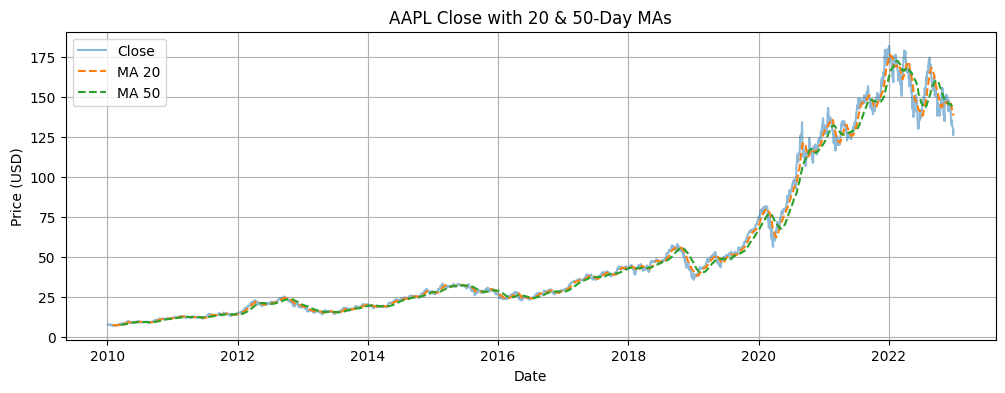

In [18]:
df["MA20"] = df["Close"].rolling(20).mean()
df["MA50"] = df["Close"].rolling(50).mean()

plt.figure(figsize=(12,4))
plt.plot(df.index, df["Close"], alpha=0.5, label="Close")
plt.plot(df.index, df["MA20"], "--", label="MA 20")
plt.plot(df.index, df["MA50"], "--", label="MA 50")
plt.title("AAPL Close with 20 & 50-Day MAs")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True); plt.show()

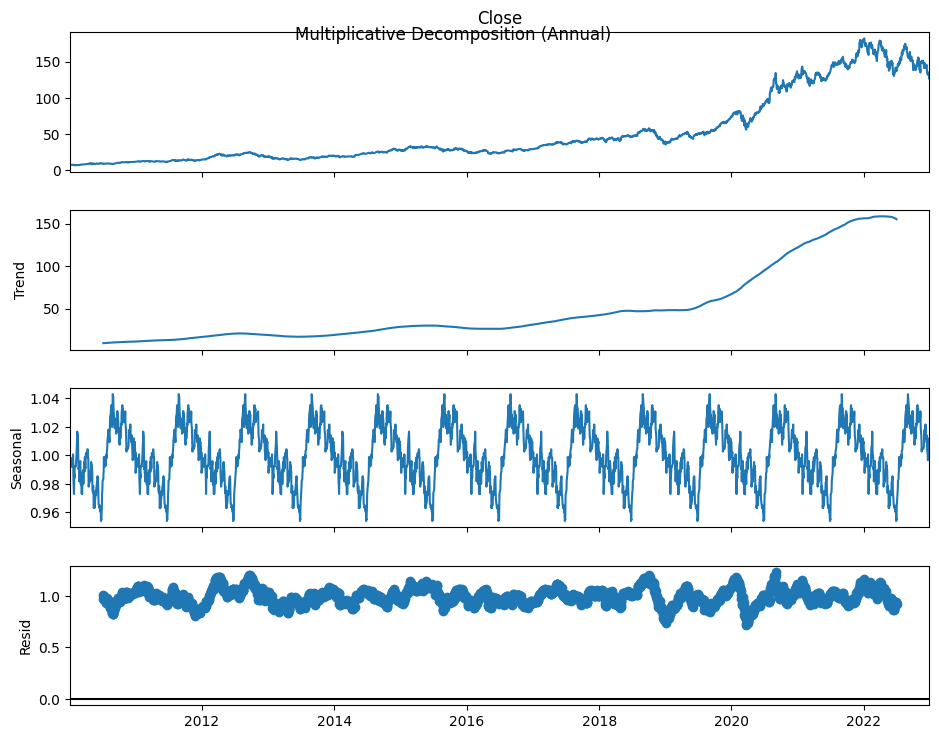

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(df["Close"].dropna(), model="multiplicative", period=252)
fig = decomp.plot()
fig.set_size_inches(10,8)
plt.suptitle("Multiplicative Decomposition (Annual)", y=0.93)
plt.show()

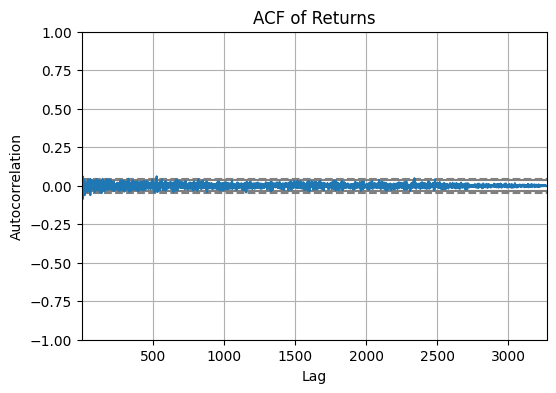

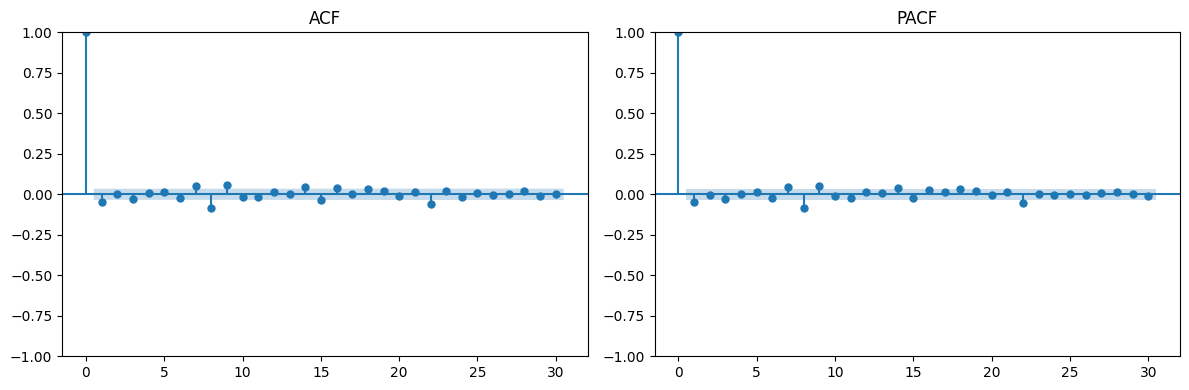

In [20]:
from pandas.plotting import autocorrelation_plot
import statsmodels.api as sm

plt.figure(figsize=(6,4))
autocorrelation_plot(df["Return"].dropna())
plt.title("ACF of Returns"); plt.show()

fig, axes = plt.subplots(1,2,figsize=(12,4))
sm.graphics.tsa.plot_acf(df["Return"].dropna(), lags=30, ax=axes[0])
sm.graphics.tsa.plot_pacf(df["Return"].dropna(), lags=30, ax=axes[1])
axes[0].set_title("ACF"); axes[1].set_title("PACF")
plt.tight_layout(); plt.show()

In [21]:
!pip install --quiet scikit-learn

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [23]:
data = df[["Close"]].copy()

for lag in range(1, 6):  
    data[f"lag_{lag}"] = data["Close"].shift(lag)

data["ma_5"]  = data["Close"].rolling(5).mean()
data["ma_20"] = data["Close"].rolling(20).mean()

data = data.dropna().copy()

data["target"] = data["Close"].shift(-1)
data = data.dropna()


In [24]:
split_date = "2022-01-01"
train = data.loc[:split_date].dropna()
test  = data.loc[split_date:].dropna()

X_train = train.drop(columns=["target"])
y_train = train["target"]
X_test  = test.drop(columns=["target"])
y_test  = test["target"]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (3002, 8) Test shape: (249, 8)


In [25]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Test MAE : 3.75
Test RMSE: 4.81


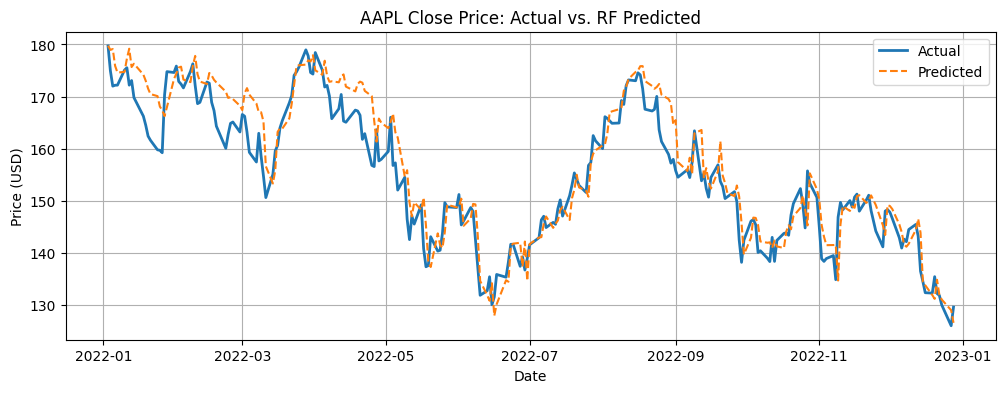

In [26]:
pred = model.predict(X_test)

mae  = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(f"Test MAE : {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")

plt.figure(figsize=(12,4))
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2)
plt.plot(y_test.index, pred,       label="Predicted", linestyle="--")
plt.title("AAPL Close Price: Actual vs. RF Predicted")
plt.xlabel("Date"); plt.ylabel("Price (USD)")
plt.legend(); plt.grid(True)
plt.show()

In [27]:
import joblib

joblib.dump(model, "aapl_rf_model.joblib")
pred_df = pd.DataFrame({
    "actual": y_test,
    "predicted": pred
}, index=y_test.index)
pred_df.to_csv("aapl_rf_predictions.csv")
print("Model saved to aapl_rf_model.joblib")
print("Predictions saved to aapl_rf_predictions.csv")

Model saved to aapl_rf_model.joblib
Predictions saved to aapl_rf_predictions.csv
